In [54]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import OneHotEncoder

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib

import umap
import umap.plot as uplot

plt.rcParams["figure.figsize"] = (11, 7)
sns.set_theme()

In [55]:
soyabean_dataset_path = '../../soybean_data_use.csv'

soya_df = pd.read_csv(soyabean_dataset_path)

soya_df.head()

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,plant-growth,leaves,leafspots-halo,leafspots-marg,leafspot-size,leaf-shread,leaf-malf,leaf-mild,stem,lodging,stem-cankers,canker-lesion,fruiting-bodies,external decay,mycelium,int-discolor,sclerotia,fruit-pods,fruit spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class
0,august,normal,gt-norm,norm,no,same-lst-yr,scattered,pot-severe,none,lt-80%,abnorm,abnorm.,absent,dna,dna,absent,absent,absent,abnorm,yes,above-sec-nde,brown,present,firm-and-dry,absent,none,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
1,september,normal,gt-norm,norm,yes,same-lst-sev-yrs,low-areas,pot-severe,fungicide,lt-80%,abnorm,abnorm.,absent,dna,dna,absent,absent,absent,abnorm,no,above-sec-nde,dna,present,firm-and-dry,absent,none,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
2,july,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,severe,fungicide,80-89%,abnorm,abnorm.,absent,dna,dna,absent,absent,absent,abnorm,yes,above-sec-nde,dna,present,firm-and-dry,absent,none,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
3,october,normal,gt-norm,norm,yes,same-lst-yr,low-areas,pot-severe,none,90-100%,abnorm,abnorm.,absent,dna,dna,absent,absent,absent,abnorm,no,above-sec-nde,brown,present,firm-and-dry,absent,none,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
4,august,normal,gt-norm,norm,yes,same-lst-sev-yrs,scattered,severe,none,lt-80%,abnorm,abnorm.,absent,dna,dna,absent,absent,absent,abnorm,yes,above-sec-nde,brown,present,firm-and-dry,absent,none,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker


In [56]:
soya_df.isna().sum().sum()

0

In [57]:
num_unique_features = soya_df.nunique()
num_unique_features

date               7
plant-stand        2
precip             3
temp               3
hail               2
crop-hist          4
area-damaged       4
severity           2
seed-tmt           2
germination        3
plant-growth       1
leaves             2
leafspots-halo     1
leafspots-marg     1
leafspot-size      1
leaf-shread        1
leaf-malf          1
leaf-mild          1
stem               1
lodging            2
stem-cankers       4
canker-lesion      4
fruiting-bodies    2
external decay     2
mycelium           2
int-discolor       2
sclerotia          2
fruit-pods         2
fruit spots        1
seed               1
mold-growth        1
seed-discolor      1
seed-size          1
shriveling         1
roots              2
class              4
dtype: int64

In [58]:
# drop the feature which has only one value

drop_columns = list(num_unique_features[num_unique_features==1].index)
drop_columns

['plant-growth',
 'leafspots-halo',
 'leafspots-marg',
 'leafspot-size',
 'leaf-shread',
 'leaf-malf',
 'leaf-mild',
 'stem',
 'fruit spots',
 'seed',
 'mold-growth',
 'seed-discolor',
 'seed-size',
 'shriveling']

In [59]:
# get the label for the feature
label = soya_df['class']

soya_df = soya_df.drop(columns=['class']+ drop_columns)
soya_df.head()

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,leaves,lodging,stem-cankers,canker-lesion,fruiting-bodies,external decay,mycelium,int-discolor,sclerotia,fruit-pods,roots
0,august,normal,gt-norm,norm,no,same-lst-yr,scattered,pot-severe,none,lt-80%,abnorm.,yes,above-sec-nde,brown,present,firm-and-dry,absent,none,absent,norm,norm
1,september,normal,gt-norm,norm,yes,same-lst-sev-yrs,low-areas,pot-severe,fungicide,lt-80%,abnorm.,no,above-sec-nde,dna,present,firm-and-dry,absent,none,absent,norm,norm
2,july,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,severe,fungicide,80-89%,abnorm.,yes,above-sec-nde,dna,present,firm-and-dry,absent,none,absent,norm,norm
3,october,normal,gt-norm,norm,yes,same-lst-yr,low-areas,pot-severe,none,90-100%,abnorm.,no,above-sec-nde,brown,present,firm-and-dry,absent,none,absent,norm,norm
4,august,normal,gt-norm,norm,yes,same-lst-sev-yrs,scattered,severe,none,lt-80%,abnorm.,yes,above-sec-nde,brown,present,firm-and-dry,absent,none,absent,norm,norm


In [60]:
# get the onehotencoder class
oh_encoder = OneHotEncoder(sparse_output=False)
encoded_features = oh_encoder.fit_transform(soya_df)

encoded_features.shape

(47, 58)

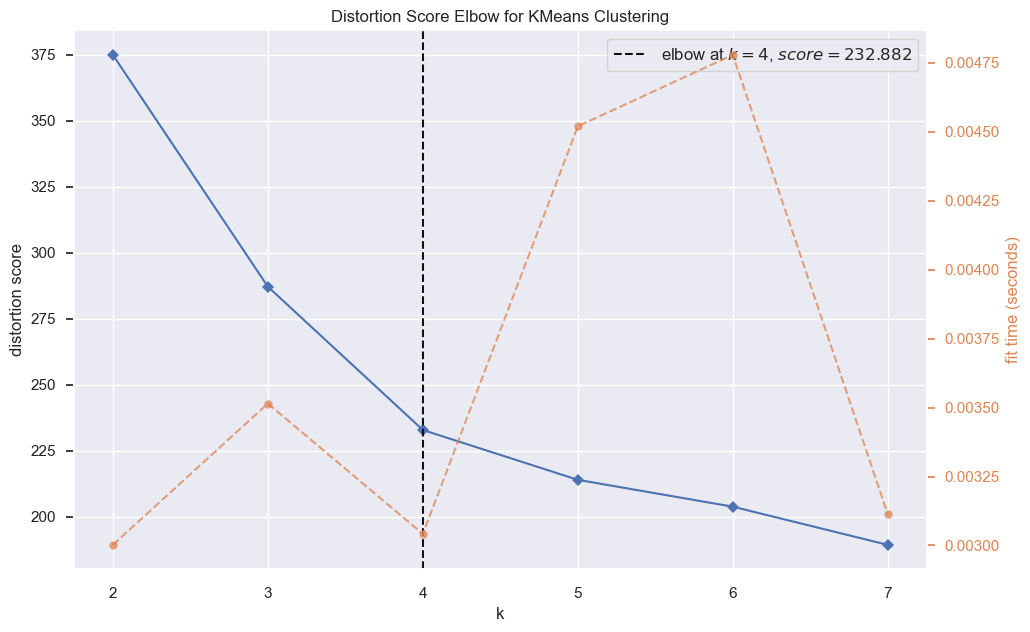

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [61]:
# perform the kmeans clustering and visualize the result
kmeans = KMeans(n_init='auto', random_state=42)
kmeans.fit_transform(encoded_features)

visualizer = KElbowVisualizer(kmeans, k=(2,3,4,5,6,7))

visualizer.fit(encoded_features)
visualizer.show()

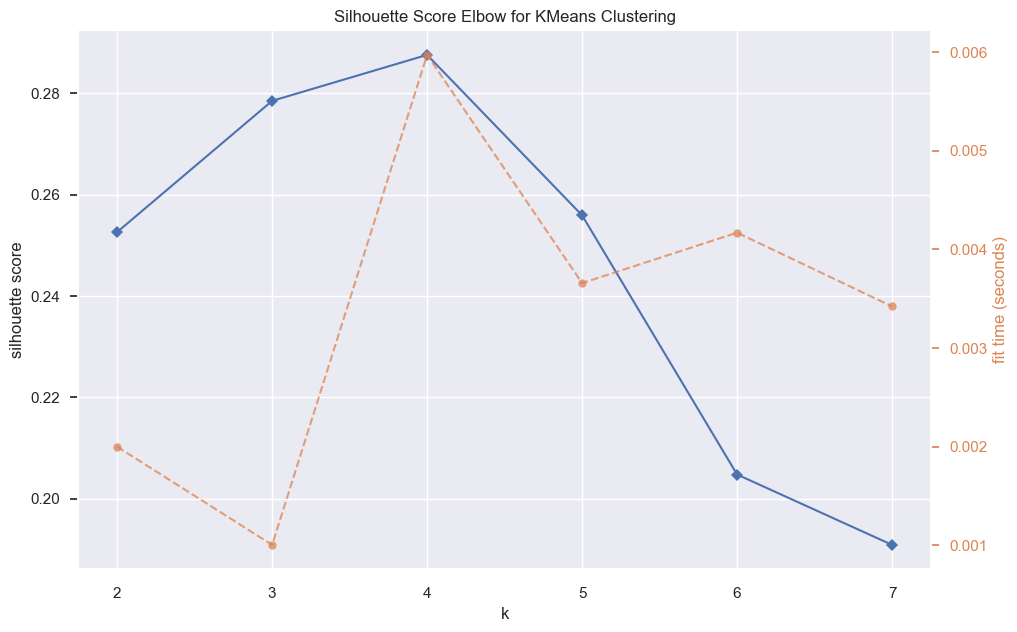

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [62]:
model = KMeans(n_init='auto', random_state=42)
model.fit_transform(encoded_features)

visualizer = KElbowVisualizer(model, k=(2,3,4,5,6,7), metric='silhouette',locate_elbow=False)
visualizer.fit(encoded_features)
visualizer.show()

<Axes: >

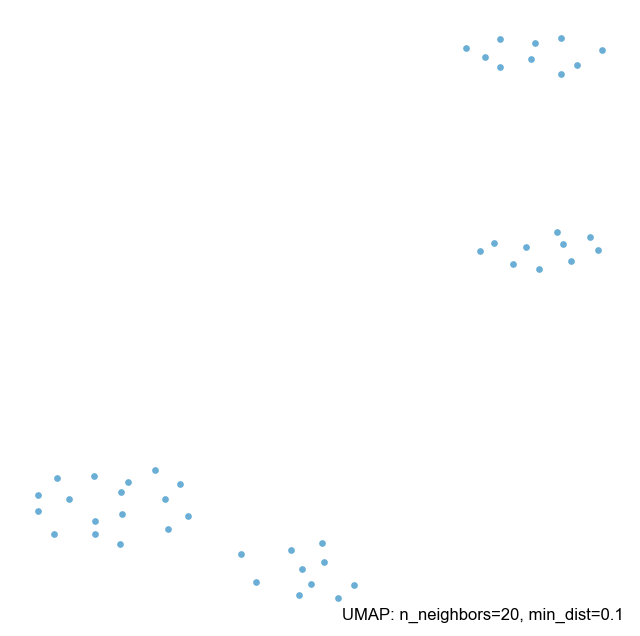

In [63]:
# calculate the umap for the given data
umap_model = umap.UMAP(n_neighbors=20, n_components=2, random_state=42)
umap_embed_data = umap_model.fit_transform(encoded_features)

uplot.points(umap_model)

<Axes: >

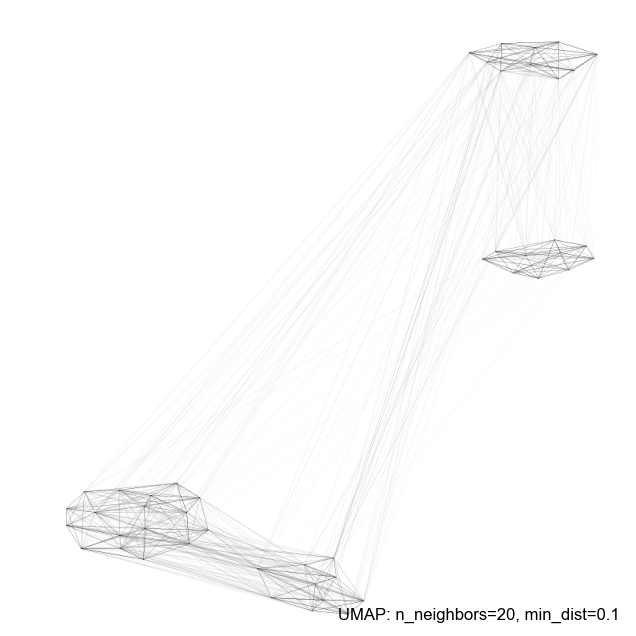

In [64]:
umap.plot.connectivity(umap_model, show_points=True)

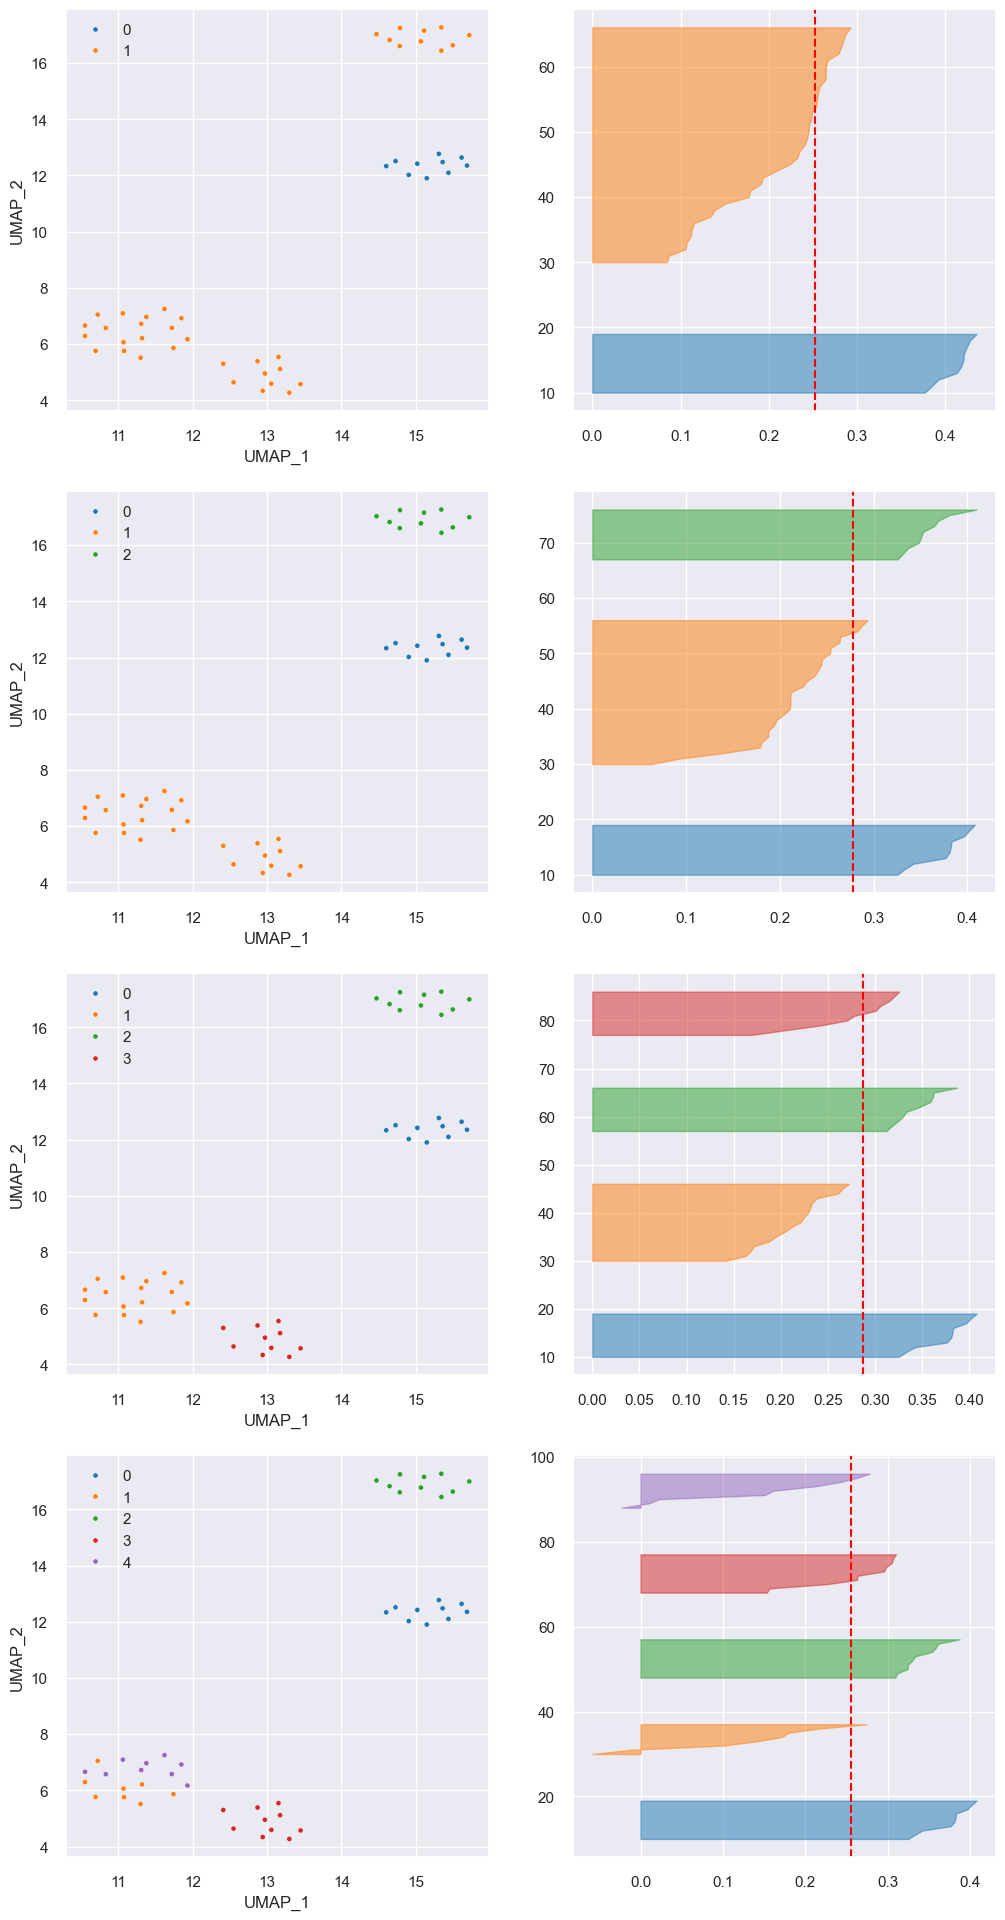

In [65]:
# perform clustering for multiple k
candidate_k = [2,3,4,5]

tab10 = list(matplotlib.colormaps['tab10'].colors)

cluster_label_dict = {}

fig, axes = plt.subplots(
    len(candidate_k), 2,
    figsize=(12,24)
)

for i , n_cluster  in enumerate(candidate_k):

    # kmeans model
    kmeans = KMeans(n_clusters=n_cluster, n_init='auto', random_state=42)
    kmeans.fit_transform(encoded_features)

    sns.scatterplot(x=umap_embed_data[:,0],
                    y=umap_embed_data[:,1],
                    s=14,
                    hue=kmeans.labels_,
                    palette='tab10',
                    ax=axes[i, 0])
    
    axes[i,0].set_xlabel('UMAP_1')
    axes[i,0].set_ylabel('UMAP_2')


    visualizer = SilhouetteVisualizer(kmeans,
                                      is_fitted=True,
                                      colors=tab10,
                                      ax=axes[i,1])
    
    visualizer.fit(encoded_features)
    cluster_label_dict[n_cluster] = kmeans.labels_

In [66]:
kmeans = KMeans(n_clusters=4, n_init='auto', random_state=42)
cluster_label = kmeans.fit_predict(encoded_features)

adjusted_rand_score(label, cluster_label)

1.0